In [166]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
import plotly.express as px
from dotenv import load_dotenv
from pathlib import Path

In [167]:
load_dotenv()

    # Получаем даты из переменных окружения
start_date = os.getenv("DATE_BEGIN")
end_date = os.getenv("DATE_END")
api_url = os.getenv("API_URL")

    # Делаем две ссылки
visit_url = f"{api_url}/visits?begin={start_date}&end={end_date}"
reg_url = f"{api_url}/registrations?begin={start_date}&end={end_date}"
# тянем данные
visits = requests.get(visit_url).json()
registrations = requests.get(reg_url).json()
df_registrations = pd.DataFrame(registrations)
df_visits = pd.DataFrame(visits)

In [168]:
def conversion_fun():

    # Теперь тянем визиты и регистрации
    visits = requests.get(visit_url)
    registrations = requests.get(reg_url)

    # Получаем данные в формате JSON
    visits = visits.json()
    registrations = registrations.json()

    # Конвертируем в датафрейм
    registrations = pd.DataFrame(registrations)
    visits = pd.DataFrame(visits)

    # Убираем ботов
    filtered_visits = visits[
        ~visits["user_agent"].str.contains("bot", case=False, na=False)
    ]

    # Конвертируем в дату
    filtered_visits["datetime"] = pd.to_datetime(filtered_visits["datetime"])
    registrations["datetime"] = pd.to_datetime(registrations["datetime"])

    # Сортируем и берем последний визит
    filtered_visits = filtered_visits.sort_values(by=["visit_id", "datetime"])
    last_visit = filtered_visits.sort_values(by=['visit_id', 'datetime']).drop_duplicates(subset=['visit_id'], keep='last')    
    #last_visit = filtered_visits.sort_values('datetime').drop_duplicates('visit_id', keep='last')

    # Группируем по датам и платформам
    # df_cleaned['date_group']=df_cleaned['registration_dt'].dt.to_period('D').dt.start_time.dt.date
    # last_visit["date_group"] = last_visit["datetime"].dt.date
    last_visit["date_group"] = last_visit["datetime"].dt.to_period('D').dt.start_time.dt.date
    df_visit = (
        last_visit.groupby(["platform", "date_group"]).size().reset_index(name="visits")
    )

    # Регистрации по датам и платформам
    registrations["date_group"] = registrations["datetime"].dt.date
    df_reg = (
        registrations.groupby(["platform", "date_group"])
        .size()
        .reset_index(name="registrations")
    )

    # Объединяем и вычисляем конверсию
    df_conversion = pd.merge(df_visit, df_reg, on=["platform", "date_group"])
    df_conversion["conversion"] = 100 * df_conversion["registrations"] / df_conversion["visits"].replace(0, np.nan)
    # df_browser = df_conversion[["date_group", "platform", "visits", "registrations", "conversion", "user_agent"]].copy()
    df_conversion = df_conversion[["date_group", "platform", "visits", "registrations", "conversion"]]
    df_conversion = df_conversion.sort_values(by=["date_group", "platform"])
    df_conversion.reset_index(drop=True, inplace=True)

    # Сохраняем в JSON
    df_conversion.to_json("./conversion.json")
   
    return df_conversion #, df_browser  
conversion_fun()

C:\Users\severin\AppData\Local\Temp\ipykernel_29208\145624367.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_visits["datetime"] = pd.to_datetime(filtered_visits["datetime"])


,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355
...,...,...,...,...,...
547,2023-08-30,ios,66,40,60.606061
548,2023-08-30,web,1227,34,2.770986
549,2023-08-31,android,57,42,73.684211
550,2023-08-31,ios,50,36,72.000000


In [169]:
df_conversion = conversion_fun()

def process_ad_data():
    df_company = pd.read_csv("ads.csv")

    df_company["date"] = pd.to_datetime(df_company["date"])
    df_company["date_group"] = df_company["date"].dt.date
    df_company.drop_duplicates(inplace=True)

    start_date = pd.to_datetime(os.getenv("DATE_BEGIN")).date()
    end_date = pd.to_datetime(os.getenv("DATE_END")).date()
    df_company = df_company[(df_company["date_group"] >= start_date) & (df_company["date_group"] <= end_date)]

    df_company = df_company.groupby(["date_group", "utm_campaign"], as_index=False)[
        "cost"
    ].sum()

    # Преобразуем стоимость в числовой формат
    df_company["cost"] = pd.to_numeric(df_company["cost"], errors='coerce').fillna(0)

    df_conversion["date_group"] = pd.to_datetime(df_conversion["date_group"]).dt.date
    ads = pd.merge(df_conversion, df_company, on=["date_group"], how="left").fillna("none")

    ads = ads[["date_group", "visits", "registrations", "cost", "utm_campaign"]]
    ads = ads.reset_index(drop=True).sort_values(by=["date_group"])

    ads.to_json("./ads.json")

    return ads
    
process_ad_data()

C:\Users\severin\AppData\Local\Temp\ipykernel_29208\145624367.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_visits["datetime"] = pd.to_datetime(filtered_visits["datetime"])


,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,75,61,212.0,advanced_algorithms_series
1,2023-03-01,22,18,212.0,advanced_algorithms_series
2,2023-03-01,279,8,212.0,advanced_algorithms_series
3,2023-03-02,67,59,252.0,advanced_algorithms_series
4,2023-03-02,31,24,252.0,advanced_algorithms_series
...,...,...,...,...,...
546,2023-08-30,35,27,109.0,intro_to_python_course
548,2023-08-30,1227,34,109.0,intro_to_python_course
550,2023-08-31,50,36,215.0,intro_to_python_course
549,2023-08-31,57,42,215.0,intro_to_python_course


In [170]:
df_conversion = conversion_fun()

def process_ad_data():
    # Загружаем данные о компаниях и конверсии
    df_company = pd.read_csv("ads.csv")

    # Преобразуем данные о компаниях
    df_company["date"] = pd.to_datetime(df_company["date"])
    df_company["date_group"] = df_company["date"].dt.date
# дропнуть дубликаты
    df_company.drop_duplicates(inplace=True)
#добавить фильтр по датам из env
    start_date = pd.to_datetime(os.getenv("DATE_BEGIN")).date()
    end_date = pd.to_datetime(os.getenv("DATE_END")).date()
    df_company = df_company[(df_company["date_group"] >= start_date) & (df_company["date_group"] <= end_date)]
    # Группируем данные по кампании и дате
    df_company = df_company.groupby(["date_group", "utm_campaign"], as_index=False)[
        "cost"
    ].sum() 

    # Преобразуем дату в данных о конверсии
    df_conversion["date_group"] = pd.to_datetime(df_conversion["date_group"]).dt.date

    # Объединяем данные о компаниях и конверсии
    ads = pd.merge(df_conversion, df_company, on=["date_group"], how="left").fillna("none")

    # Определяем порядок колонок
    ads = ads[["date_group", "visits", "registrations", "cost", "utm_campaign"]]
    ads = ads.reset_index(drop=True).sort_values(by=["date_group"])

    # Сохраняем итоговые данные в JSON
    ads.to_json("./ads.json")

    return ads
    
process_ad_data()

C:\Users\severin\AppData\Local\Temp\ipykernel_29208\145624367.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_visits["datetime"] = pd.to_datetime(filtered_visits["datetime"])


,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,75,61,212.0,advanced_algorithms_series
1,2023-03-01,22,18,212.0,advanced_algorithms_series
2,2023-03-01,279,8,212.0,advanced_algorithms_series
3,2023-03-02,67,59,252.0,advanced_algorithms_series
4,2023-03-02,31,24,252.0,advanced_algorithms_series
...,...,...,...,...,...
546,2023-08-30,35,27,109.0,intro_to_python_course
548,2023-08-30,1227,34,109.0,intro_to_python_course
550,2023-08-31,50,36,215.0,intro_to_python_course
549,2023-08-31,57,42,215.0,intro_to_python_course


In [171]:
conversion = df_conversion
ads = process_ad_data()
# Готовим данные для conversion
conversion["date_group"] = pd.to_datetime(conversion["date_group"])
conversion["month"] = conversion["date_group"].dt.to_period("M")

# Готовим данные для ads
ads["date_group"] = pd.to_datetime(ads["date_group"])
ads["month"] = ads["date_group"].dt.to_period("M")

# Создаем сводную таблицу
pivot_conversion = pd.pivot_table(
    conversion,
    index="month",
    columns="platform",
    values=["visits", "registrations", "conversion"],
    aggfunc={"visits": "sum", "registrations": "sum", "conversion": "mean"},
    fill_value=0,
)

pivot_ads = pd.pivot_table(
    ads,
    index="month",
    columns="utm_campaign",
    values=["visits", "registrations", "cost"],
    aggfunc="sum",
    fill_value=0,
)

# Подсчитываем суммарные визиты и регистрации по месяцам
total_visits = pivot_conversion["visits"].sum(axis=1)
total_regs = pivot_conversion["registrations"].sum(axis=1)
total_convers = pivot_conversion["conversion"]

C:\Users\severin\AppData\Local\Temp\ipykernel_29208\4215920407.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot_ads = pd.pivot_table(


In [172]:
p = Path.cwd()
d = p / 'charts'
d.mkdir(exist_ok=True)

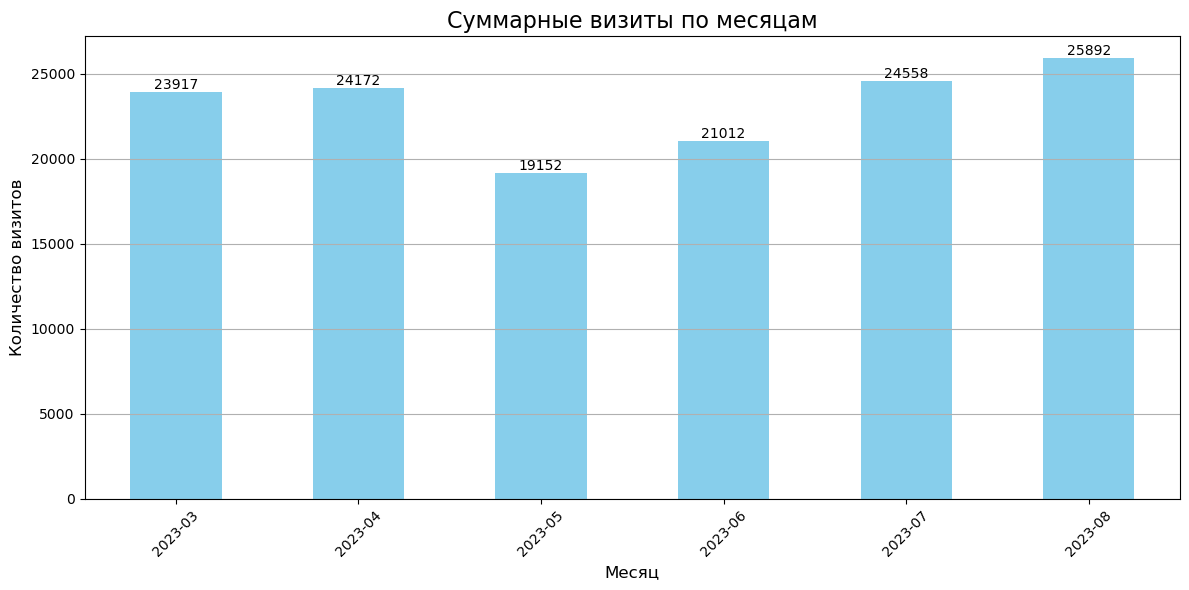

In [173]:
def plot_total_visits():
    plt.figure(figsize=(12, 6))
    bars = total_visits.plot(kind="bar", color="skyblue")
    for bar in bars.patches:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, yval, int(yval), va="bottom", ha="center"
        )
    plt.title("Суммарные визиты по месяцам", fontsize=16)
    plt.xlabel("Месяц", fontsize=12)
    plt.ylabel("Количество визитов", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.savefig("./charts/total_visits_per_month.png")
    plt.show()
plot_total_visits()

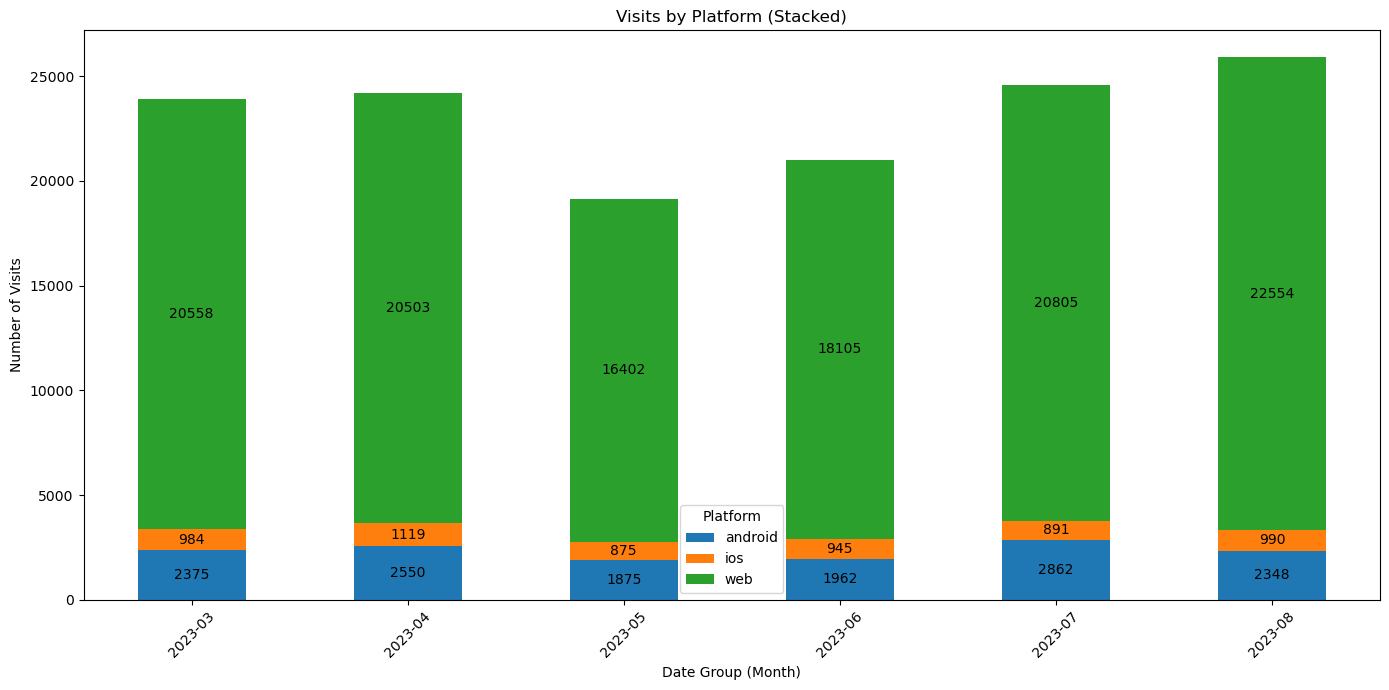

In [174]:
def plot_visits_by_platform():
    ax = pivot_conversion["visits"].plot(kind="bar", stacked=True, figsize=(14, 7))
    plt.title("Visits by Platform (Stacked)")
    plt.xlabel("Date Group (Month)")
    plt.ylabel("Number of Visits")
    plt.xticks(rotation=45)
    plt.legend(title="Platform")
    plt.tight_layout()
    for i in range(pivot_conversion["visits"].shape[0]):
        cumulative_height = 0
        for j in range(pivot_conversion["visits"].shape[1]):
            value = pivot_conversion["visits"].iloc[i, j]
            cumulative_height += value
            if value > 0:
                ax.text(
                    i,
                    cumulative_height - value / 2,
                    str(value),
                    ha="center",
                    va="center",
                )
    plt.savefig("./charts/visits_by_platform.png")
    plt.show()
plot_visits_by_platform()

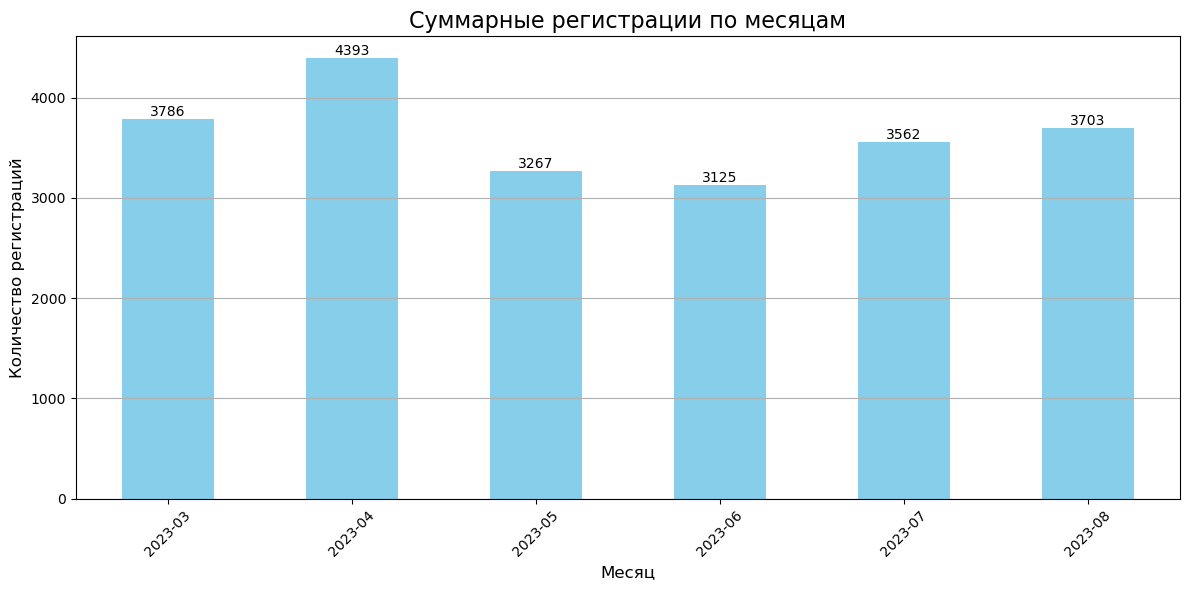

In [175]:
def plot_total_regs():
    plt.figure(figsize=(12, 6))
    bars = total_regs.plot(kind="bar", color="skyblue")
    for bar in bars.patches:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, yval, int(yval), va="bottom", ha="center"
        )
    plt.title("Суммарные регистрации по месяцам", fontsize=16)
    plt.xlabel("Месяц", fontsize=12)
    plt.ylabel("Количество регистраций", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.savefig("./charts/total_regs_per_month.png")
    plt.show()
plot_total_regs()

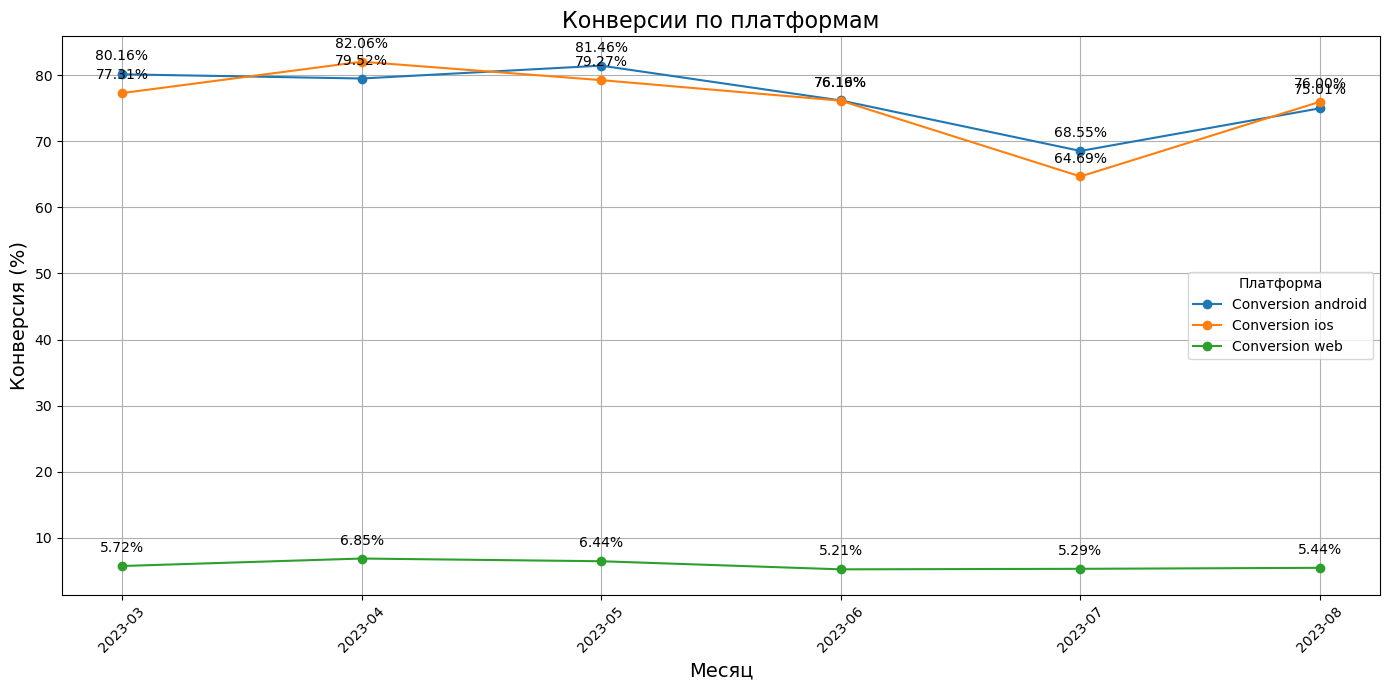

In [176]:
def plot_conversion_by_platform():
    plt.figure(figsize=(14, 7))
    for platform in pivot_conversion["conversion"].columns:
        plt.plot(
            total_convers.index.astype(str),
            total_convers[platform],
            marker="o",
            linestyle="-",
            label=f"Conversion {platform}",
        )
        for i, val in enumerate(total_convers[platform]):
            plt.annotate(
                f"{val:.2f}%",
                (
                    total_convers.index[i].strftime("%Y-%m"),
                    total_convers[platform].iloc[i],
                ),
                textcoords="offset points",
                xytext=(0, 10),
                ha="center",
            )
    plt.title("Конверсии по платформам", fontsize=16)
    plt.xlabel("Месяц", fontsize=14)
    plt.ylabel("Конверсия (%)", fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title="Платформа")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("./charts/conversion_by_platform.png")
    plt.show()
plot_conversion_by_platform()

<Figure size 1400x700 with 0 Axes>

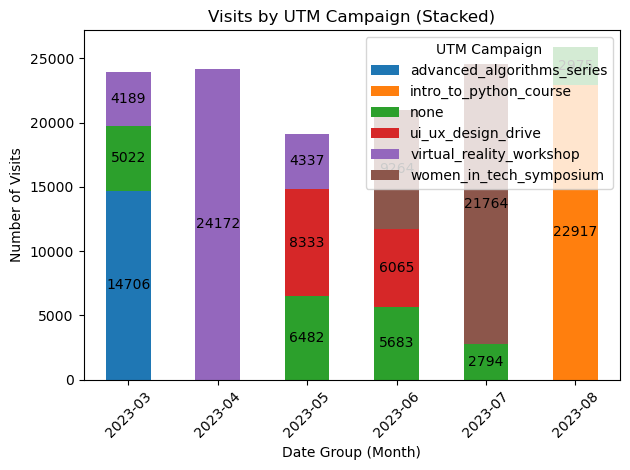

In [177]:
def plot_ads_visits():
    plt.figure(figsize=(14, 7))
    ax = pivot_ads["visits"].plot(kind="bar", stacked=True)
    plt.title("Visits by UTM Campaign (Stacked)")
    plt.xlabel("Date Group (Month)")
    plt.ylabel("Number of Visits")
    plt.xticks(rotation=45)
    plt.legend(title="UTM Campaign")
    plt.tight_layout()
    for i in range(pivot_ads["visits"].shape[0]):
        cumulative_height = 0
        for j in range(pivot_ads["visits"].shape[1]):
            value = pivot_ads["visits"].iloc[i, j]
            cumulative_height += value
            if value > 0:
                ax.text(
                    i,
                    cumulative_height - value / 2,
                    str(value),
                    ha="center",
                    va="center",
                )
    plt.savefig("./charts/ads_visits_by_campaign.png")
    plt.show()
plot_ads_visits()

<Figure size 1400x700 with 0 Axes>

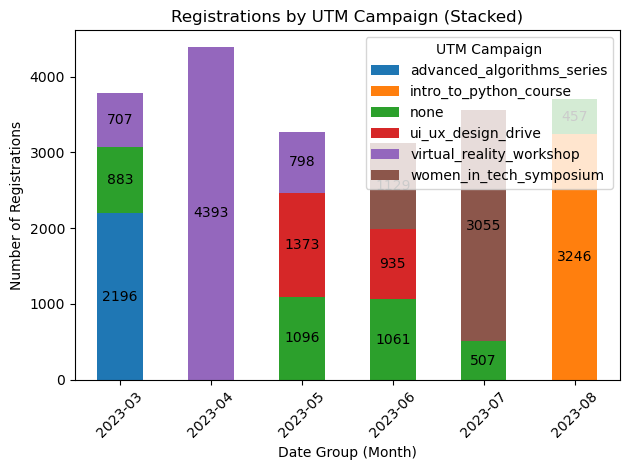

In [178]:
def plot_ads_regs():
    plt.figure(figsize=(14, 7))
    ax = pivot_ads["registrations"].plot(kind="bar", stacked=True)
    plt.title("Registrations by UTM Campaign (Stacked)")
    plt.xlabel("Date Group (Month)")
    plt.ylabel("Number of Registrations")
    plt.xticks(rotation=45)
    plt.legend(title="UTM Campaign")
    plt.tight_layout()
    for i in range(pivot_ads["registrations"].shape[0]):
        cumulative_height = 0
        for j in range(pivot_ads["registrations"].shape[1]):
            value = pivot_ads["registrations"].iloc[i, j]
            cumulative_height += value
            if value > 0:
                ax.text(
                    i,
                    cumulative_height - value / 2,
                    str(value),
                    ha="center",
                    va="center",
                )
    plt.savefig("./charts/ads_regs_by_campaign.png")
    plt.show()
plot_ads_regs()

<Figure size 1400x700 with 0 Axes>

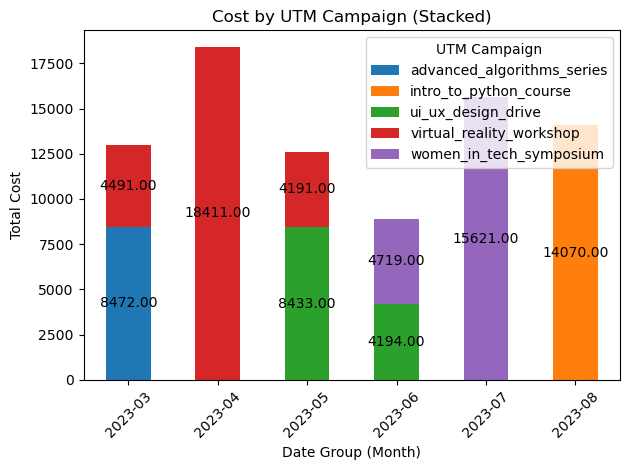

In [179]:
def plot_ads_cost():
    plt.figure(figsize=(14, 7))
    ax = pivot_ads["cost"].plot(kind="bar", stacked=True)
    plt.title("Cost by UTM Campaign (Stacked)")
    plt.xlabel("Date Group (Month)")
    plt.ylabel("Total Cost")
    plt.xticks(rotation=45)
    plt.legend(title="UTM Campaign")
    plt.tight_layout()
    
    for i in range(pivot_ads["cost"].shape[0]):
        cumulative_height = 0
        for j in range(pivot_ads["cost"].shape[1]):
            # Получаем значение и обрабатываем потенциальные нечисловые значения
            try:
                # Пытаемся конвертировать в float, если возможно
                value = float(pivot_ads["cost"].iloc[i, j])
                cumulative_height += value
                if value > 0:
                    ax.text(
                        i,
                        cumulative_height - value / 2,
                        f"{value:.2f}",  # Форматируем строку с 2 десятичными знаками
                        ha="center",
                        va="center",
                    )
            except (ValueError, TypeError):
                # Пропускаем это значение, если его не удается конвертировать в float
                continue
    
    plt.savefig("./charts/ads_cost_by_campaign.png")
    plt.show()

plot_ads_cost()

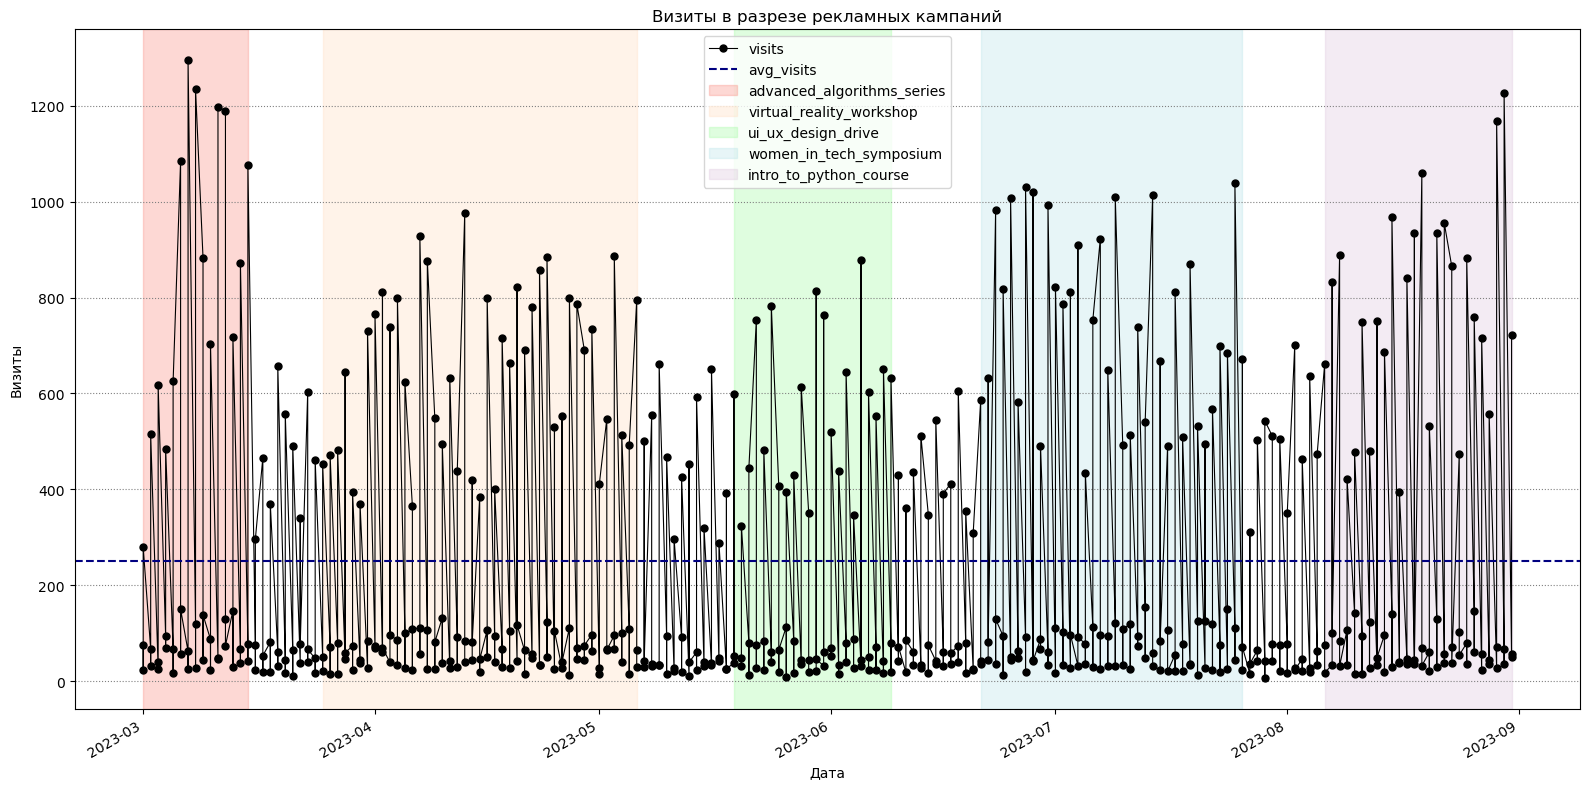

In [180]:
def plot_visits_with_campaigns():
    visits_color = ads.copy()
    visits_color['date_group'] = pd.to_datetime(visits_color['date_group'])

    # Создаем колонку с номерами кампаний
    visits_color['campaigns_n'] = (visits_color['utm_campaign'] != visits_color['utm_campaign'].shift()).cumsum()

    # Фильтруем данные, исключая строки с 'none'
    campaign_periods = (visits_color
                        .dropna(subset=['utm_campaign'])
                        .loc[visits_color['utm_campaign'] != 'none']  # Исключаем 'none'
                        .groupby(['campaigns_n', 'utm_campaign'])
                        .agg(start=('date_group', 'min'), finish=('date_group', 'max'))
                        .reset_index()
                       )

    # Строим график
    visits_color.plot(x='date_group', y='visits', kind='line', figsize=(16, 8), 
                      linewidth=0.8, color='black', label='visits', marker='o', markersize=5)
    
    plt.axhline(visits_color['visits'].mean(), linestyle='--', color='navy', label='avg_visits')

    # Добавляем цветные области для каждой рекламной кампании
    colors = ['salmon', 'peachpuff', 'palegreen', 'powderblue', 'thistle']
    for i, row in campaign_periods.iterrows():
        plt.axvspan(row['start'], row['finish'], color=colors[i % len(colors)], alpha=0.3, label=row['utm_campaign'])

    # Оформление графика
    plt.grid(axis='y', linestyle=':', color='grey')
    plt.legend(loc='best')
    plt.title('Визиты в разрезе рекламных кампаний')
    plt.xlabel('Дата')
    plt.ylabel('Визиты')
    plt.tight_layout()
    
    plt.savefig('./charts/visits_during_campaigns.png')
    plt.show()

plot_visits_with_campaigns()

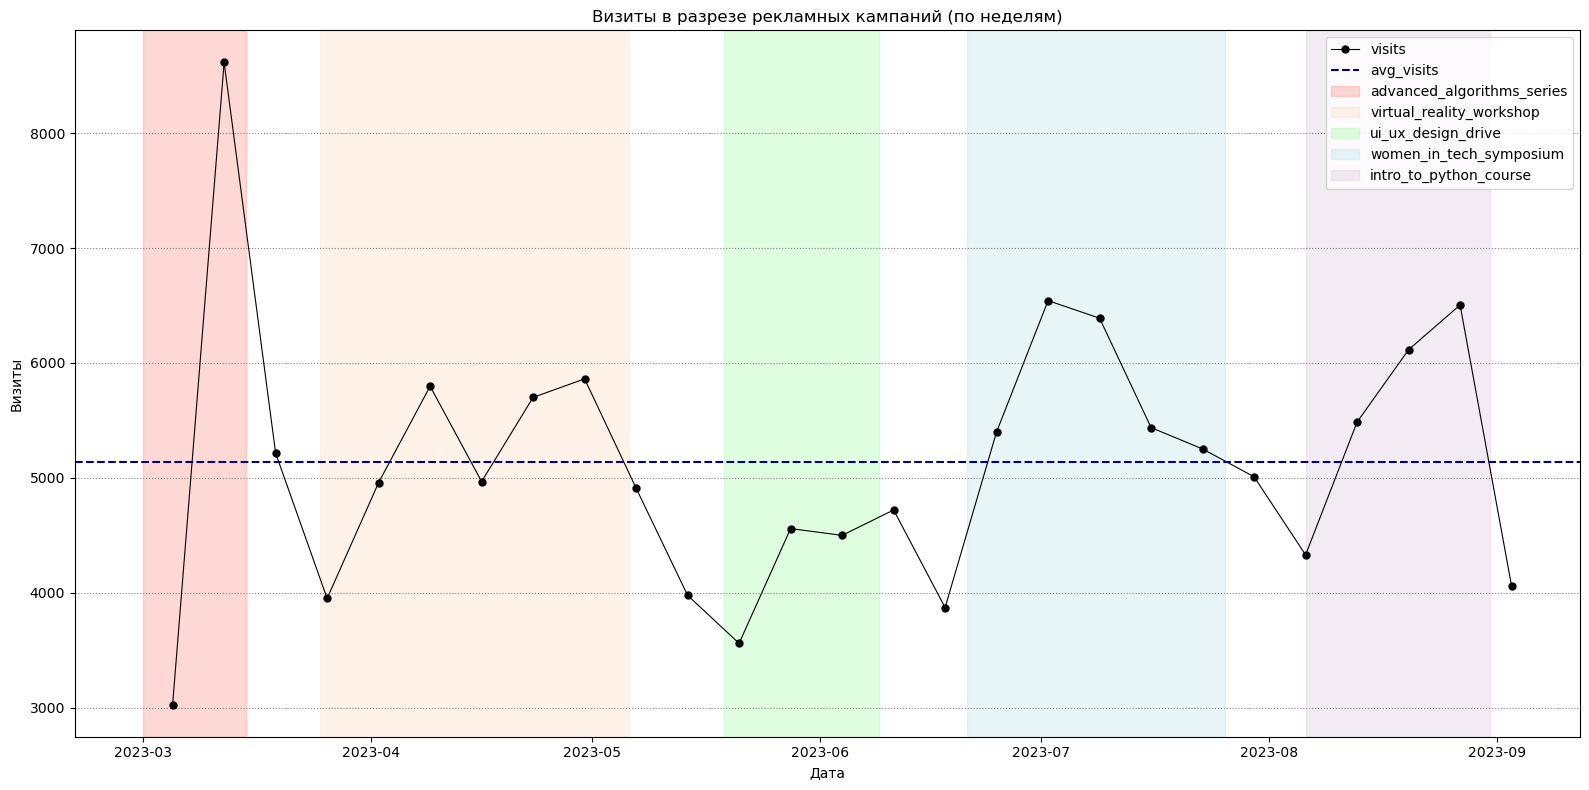

In [181]:
def plot_visits_weekly_campaigns():
    visits_color = ads.copy()
    visits_color['date_group'] = pd.to_datetime(visits_color['date_group'])

    # Создаем колонку с номерами кампаний
    visits_color['campaigns_n'] = (visits_color['utm_campaign'] != visits_color['utm_campaign'].shift()).cumsum()

    # Убедитесь, что столбец 'visits' является числовым
    visits_color['visits'] = pd.to_numeric(visits_color['visits'], errors='coerce')

    # Удаляем строки с NaN в 'utm_campaign' или 'visits'
    visits_color = visits_color.dropna(subset=['utm_campaign', 'visits'])

    # Исключаем строки с 'none' в 'utm_campaign'
    campaign_periods = (visits_color
                        .loc[visits_color['utm_campaign'] != 'none']
                        .groupby(['campaigns_n', 'utm_campaign'])
                        .agg(start=('date_group', 'min'), finish=('date_group', 'max'))
                        .reset_index()
                       )

    # Теперь мы будем группировать по неделям
    visits_by_week = visits_color.set_index('date_group').resample('W').sum(numeric_only=True).reset_index()

    # Строим график для сумм по неделям
    plt.figure(figsize=(16, 8))
    plt.plot(visits_by_week['date_group'], visits_by_week['visits'], 
             linewidth=0.8, color='black', label='visits', marker='o', markersize=5)
    
    plt.axhline(visits_by_week['visits'].mean(), linestyle='--', color='navy', label='avg_visits')

    # Добавляем цветные области для каждой рекламной кампании
    colors = ['salmon', 'peachpuff', 'palegreen', 'powderblue', 'thistle']
    for i, row in campaign_periods.iterrows():
        plt.axvspan(row['start'], row['finish'], color=colors[i % len(colors)], alpha=0.3, label=row['utm_campaign'])

    # Оформление графика
    plt.grid(axis='y', linestyle=':', color='grey')
    plt.legend(loc='best')
    plt.title('Визиты в разрезе рекламных кампаний (по неделям)')
    plt.xlabel('Дата')
    plt.ylabel('Визиты')
    plt.tight_layout()

    plt.savefig('./charts/visits_week_campaigns.png')
    plt.show()

plot_visits_weekly_campaigns()

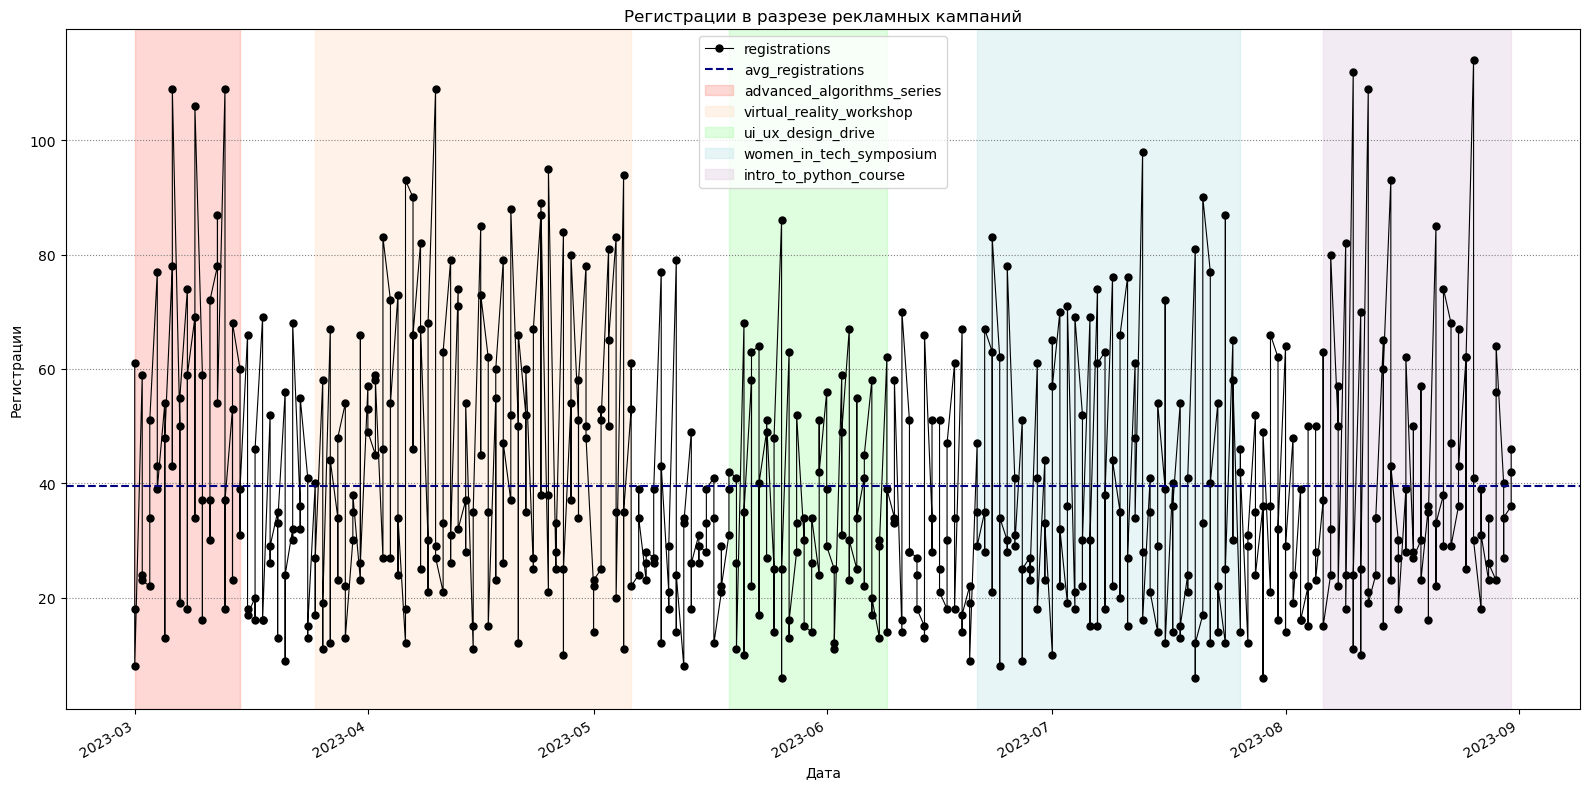

In [182]:
def plot_registrations_with_campaigns():
    registrations_color = ads.copy()
    registrations_color['date_group'] = pd.to_datetime(registrations_color['date_group'])

    # Создаем колонку с номерами кампаний
    registrations_color['campaigns_n'] = (registrations_color['utm_campaign'] != registrations_color['utm_campaign'].shift()).cumsum()

    # Фильтруем данные, исключая строки с 'none'
    campaign_periods = (registrations_color
                        .dropna(subset=['utm_campaign'])
                        .loc[registrations_color['utm_campaign'] != 'none']  # Исключаем 'none'
                        .groupby(['campaigns_n', 'utm_campaign'])
                        .agg(start=('date_group', 'min'), finish=('date_group', 'max'))
                        .reset_index()
                       )

    # Строим график
    registrations_color.plot(x='date_group', y='registrations', kind='line', figsize=(16, 8), 
                             linewidth=0.8, color='black', label='registrations', marker='o', markersize=5)
    
    plt.axhline(registrations_color['registrations'].mean(), linestyle='--', color='navy', label='avg_registrations')

    # Добавляем цветные области для каждой рекламной кампании
    colors = ['salmon', 'peachpuff', 'palegreen', 'powderblue', 'thistle']
    for i, row in campaign_periods.iterrows():
        plt.axvspan(row['start'], row['finish'], color=colors[i % len(colors)], alpha=0.3, label=row['utm_campaign'])

    # Оформление графика
    plt.grid(axis='y', linestyle=':', color='grey')
    plt.legend(loc='best')
    plt.title('Регистрации в разрезе рекламных кампаний')
    plt.xlabel('Дата')
    plt.ylabel('Регистрации')
    plt.tight_layout()
    
    plt.savefig('./charts/registrations_during_campaigns.png')
    plt.show()

# Пример вызова функции
plot_registrations_with_campaigns()

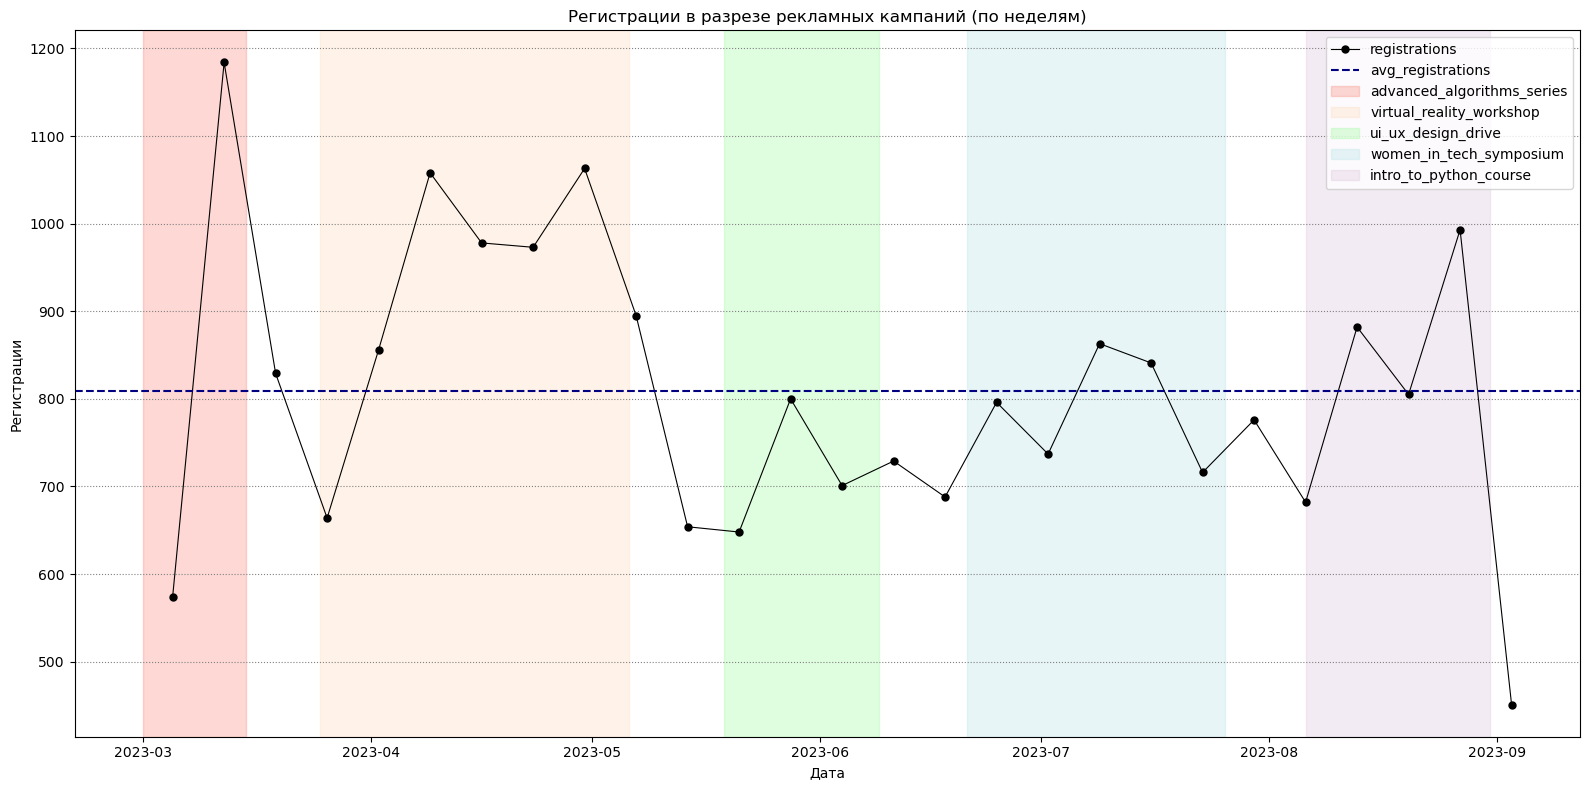

In [183]:
def plot_registrations_weekly_campaigns():
    registrations_color = ads.copy()
    registrations_color['date_group'] = pd.to_datetime(registrations_color['date_group'])

    # Создаем колонку с номерами кампаний
    registrations_color['campaigns_n'] = (registrations_color['utm_campaign'] != registrations_color['utm_campaign'].shift()).cumsum()

    # Убедитесь, что столбец 'registrations' является числовым
    registrations_color['registrations'] = pd.to_numeric(registrations_color['registrations'], errors='coerce')

    # Удаляем строки с NaN в 'utm_campaign' или 'registrations'
    registrations_color = registrations_color.dropna(subset=['utm_campaign', 'registrations'])

    # Исключаем строки с 'none' в 'utm_campaign'
    campaign_periods = (registrations_color
                        .loc[registrations_color['utm_campaign'] != 'none']
                        .groupby(['campaigns_n', 'utm_campaign'])
                        .agg(start=('date_group', 'min'), finish=('date_group', 'max'))
                        .reset_index()
                       )

    # Теперь мы будем группировать по неделям
    registrations_by_week = registrations_color.set_index('date_group').resample('W').sum(numeric_only=True).reset_index()

    # Строим график для сумм по неделям
    plt.figure(figsize=(16, 8))
    plt.plot(registrations_by_week['date_group'], registrations_by_week['registrations'], 
             linewidth=0.8, color='black', label='registrations', marker='o', markersize=5)
    
    plt.axhline(registrations_by_week['registrations'].mean(), linestyle='--', color='navy', label='avg_registrations')

    # Добавляем цветные области для каждой рекламной кампании
    colors = ['salmon', 'peachpuff', 'palegreen', 'powderblue', 'thistle']
    for i, row in campaign_periods.iterrows():
        plt.axvspan(row['start'], row['finish'], color=colors[i % len(colors)], alpha=0.3, label=row['utm_campaign'])

    # Оформление графика
    plt.grid(axis='y', linestyle=':', color='grey')
    plt.legend(loc='best')
    plt.title('Регистрации в разрезе рекламных кампаний (по неделям)')
    plt.xlabel('Дата')
    plt.ylabel('Регистрации')
    plt.tight_layout()

    plt.savefig('./charts/registrations_week_campaigns.png')
    plt.show()

plot_registrations_weekly_campaigns()

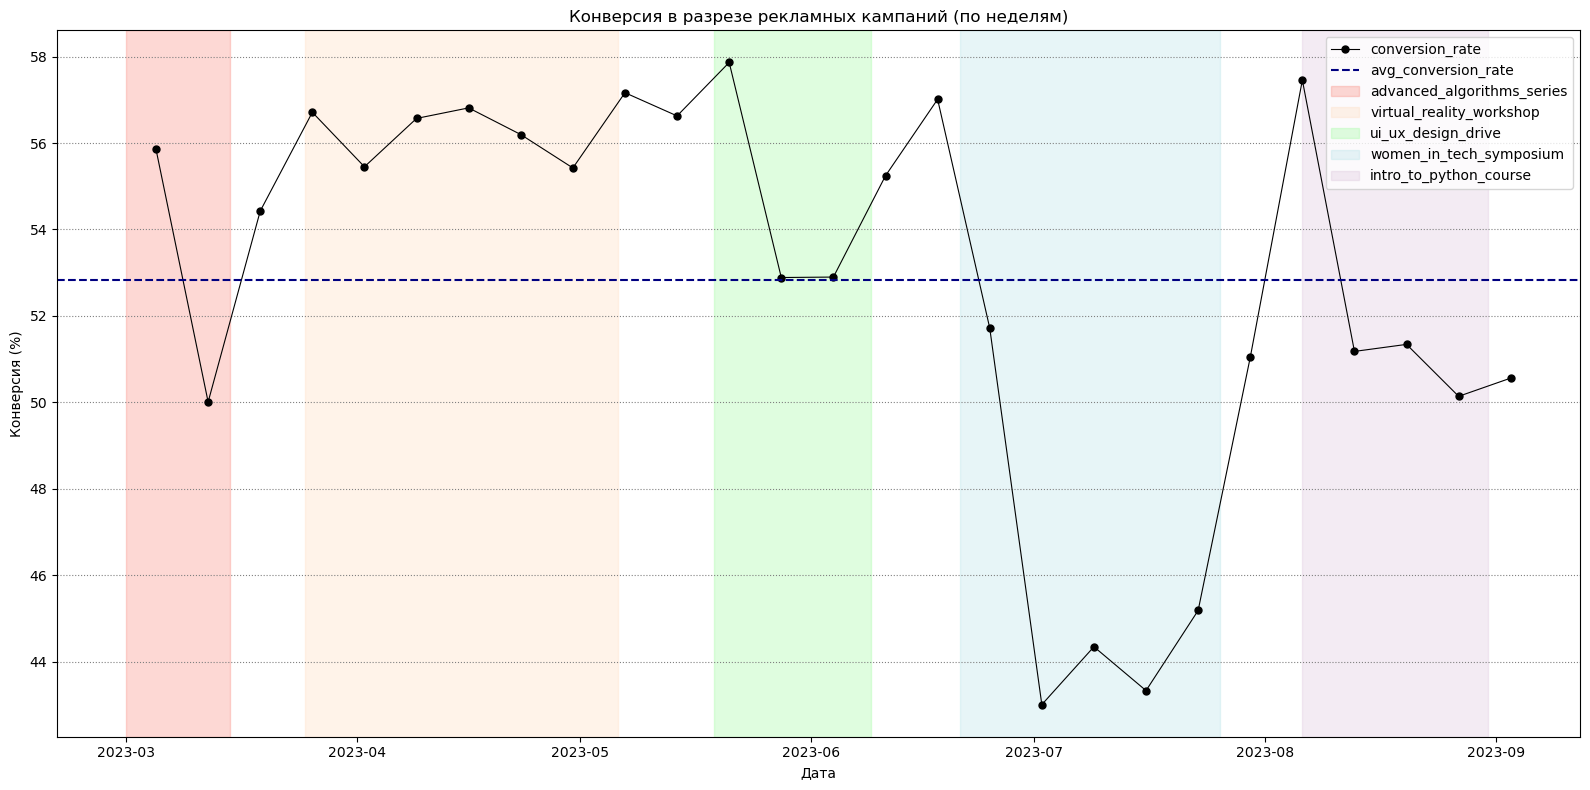

In [184]:
def plot_conversions_weekly_campaigns():
    # Копируем данные
    conversions_color = ads.copy()
    conversions_color['date_group'] = pd.to_datetime(conversions_color['date_group'])

    # Создаем колонку с номерами кампаний
    conversions_color['campaigns_n'] = (conversions_color['utm_campaign'] != conversions_color['utm_campaign'].shift()).cumsum()

    # Убедитесь, что столбцы 'registrations' и 'visits' являются числовыми
    conversions_color['registrations'] = pd.to_numeric(conversions_color['registrations'], errors='coerce')
    conversions_color['visits'] = pd.to_numeric(conversions_color['visits'], errors='coerce')

    # Удаляем строки с NaN в 'utm_campaign', 'registrations' или 'visits'
    conversions_color = conversions_color.dropna(subset=['utm_campaign', 'registrations', 'visits'])

    # Исключаем строки с 'none' в 'utm_campaign'
    campaign_periods = (conversions_color
                        .loc[conversions_color['utm_campaign'] != 'none']
                        .groupby(['campaigns_n', 'utm_campaign'])
                        .agg(start=('date_group', 'min'), finish=('date_group', 'max'))
                        .reset_index()
                       )

    # Рассчитываем конверсию
    conversions_color['conversion_rate'] = conversions_color['registrations'] / conversions_color['visits'] * 100

    # Теперь будем группировать по неделям
    conversions_by_week = conversions_color.set_index('date_group').resample('W').agg({
        'conversion_rate': 'mean',
    }).reset_index()

    # Строим график для сумм по неделям
    plt.figure(figsize=(16, 8))
    plt.plot(conversions_by_week['date_group'], conversions_by_week['conversion_rate'],
             linewidth=0.8, color='black', label='conversion_rate', marker='o', markersize=5)

    plt.axhline(conversions_by_week['conversion_rate'].mean(), linestyle='--', color='navy', label='avg_conversion_rate')

    # Добавляем цветные области для каждой рекламной кампании
    colors = ['salmon', 'peachpuff', 'palegreen', 'powderblue', 'thistle']
    for i, row in campaign_periods.iterrows():
        plt.axvspan(row['start'], row['finish'], color=colors[i % len(colors)], alpha=0.3, label=row['utm_campaign'])

    # Оформление графика
    plt.grid(axis='y', linestyle=':', color='grey')
    plt.legend(loc='best')
    plt.title('Конверсия в разрезе рекламных кампаний (по неделям)')
    plt.xlabel('Дата')
    plt.ylabel('Конверсия (%)')
    plt.tight_layout()

    plt.savefig('./charts/conversion_rate_week_campaigns.png')
    plt.show()

plot_conversions_weekly_campaigns()